# County Inflow and Outflow Prediction Problem
    This notebook predicts the inflow and outflow of California counties using data from 2014 to 2019. We are able to model and evaluate the effectiveness of models in predicting population changes to better understand reasoning for inflow and outflow in California. By aggregating county level data from a variety of public sources covering political views, weather, income, unemployment, theft, housing prices, demographics, and more, we are able to create an accurate prediction of future population trends before the pandemic. The purpose of this project is two fold. First, model evaluation can help us better understand the reason for population changes across counties in California as a baseline to better understand the habits of modern citizens. Second, although the COVID-19 pandemic has had a huge impact on county populations across the United States and world, an accurate prediction can provide a baseline for what trends a county may expect to see in future as things return to a greater normalcy.   
#
### Approach to Analysis
    Our approach in this prediction problem includes creation of a training and testing set, data preprocessing using scalers, model input for optimization of euclidean Distance, and evaluating model performance and decisions. By utilizing the scikitlearn library, we test and evaluate the effectiveness of four models: logistic regression, support vector machines, random forest regressor, and gradient boosted trees. As the dataset is small, we utilize cross validation to get the best result with small data. We also use grid search for parameter optimization. Finally, we conclude which of the four models is most effective and which fields are most important in its preformance.  

In [ ]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import altair as alt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Import dataset
ca_df = pd.read_csv('/work/cleaned-csvs/ca_counties_full_dataset.csv')
print(ca_df.shape)
ca_df.head()

(348, 82)


,county_name,year,registered_pct,democrat_pct,republican_pct,american_independent_pct,green_pct,liberterian_pct,peace_and_freedom_pct,no_party_pct,...,tornado,toxic_substances,typhoon,volcano,individual_inflow,individual_outflow,area_land,area_water,longitude,latitude
0,alameda,2014,78.523182,55.470517,13.380565,2.041992,1.237333,0.517193,0.360684,21.249642,...,0.0,0.0,0.0,0.0,72360,71551,1.909598e+09,216923745.0,-121.892901,37.646269
1,alpine,2014,87.015945,36.649215,29.842932,3.926702,1.701571,0.785340,0.130890,26.047120,...,0.0,0.0,0.0,0.0,0,0,1.912293e+09,12557304.0,-119.822348,38.596771
2,amador,2014,78.208551,31.094336,44.162900,4.370613,0.572170,1.077027,0.235600,18.203673,...,0.0,0.0,0.0,0.0,1605,1344,1.539934e+09,29470567.0,-120.653628,38.444795
3,butte,2014,70.024791,33.014476,36.155673,3.544590,1.230607,1.059547,0.427223,23.100687,...,0.0,0.0,0.0,0.0,7147,7017,4.238438e+09,105311003.0,-121.600520,39.667277
4,calaveras,2014,76.305923,30.220186,41.909266,4.706665,0.886656,1.363233,0.365746,19.668982,...,0.0,0.0,0.0,0.0,2292,2109,2.641829e+09,43797659.0,-120.552913,38.205371


## Create Train and Test Sets
    To start, we create training and test sets that can be imputed into each model. An important note is that we exchange each inflow and outflow value for its corresponding value in the next year. This allows our models to use the current public data to predict the population changes of the following year. This is important because it gives our models the ability to forecast into the future. The downside is that this decreases the number of years of data that our model can learn from by one. We then drop fields that were useful in data aggregation but not modeling. Then we split years 2014-2017 as our training set, 2018 as our test set, and 2019 for predictions without validation (as we don't have data on 2020 migration.) 

In [ ]:
year_offset = ca_df[ca_df['year']>=2015]

offset_in = {}
offset_out = {}

# Creating a dictionary for exhisting years
for yr_in_out in zip(year_offset['year'], year_offset['county'], year_offset['individual_inflow'], year_offset['individual_outflow']):
    yr_cty_indexer = str(yr_in_out[0] - 1) + str(yr_in_out[1])
    inflow = yr_in_out[2]
    outflow = yr_in_out[3]
    offset_in[yr_cty_indexer] = inflow
    offset_out[yr_cty_indexer] = outflow

# Adding in np.nan for 2019 because we don't have inflow/outflow data for 2020
no_information = ca_df[ca_df['year']==2019]
for yr_cty in zip(no_information['year'], year_offset['county']):
    yr_cty_indexer = str(yr_cty[0]) + str(yr_cty[1])
    offset_in[yr_cty_indexer] = np.nan
    offset_out[yr_cty_indexer] = np.nan



In [ ]:
# Adding new fields to ca_df_offset
ca_df_offset = ca_df.copy()
ca_df_offset['yr_cty_indexer'] = [str(yr_cty[0])+str(yr_cty[1]) for yr_cty in zip(ca_df_offset['year'], ca_df_offset['county'])]
ca_df_offset['new_inflow'] = [offset_in[indexer] for indexer in ca_df_offset['yr_cty_indexer']]
ca_df_offset['new_outflow'] = [offset_out[indexer] for indexer in ca_df_offset['yr_cty_indexer']]

# Sanity check
ca_df_offset[['year', 'county', 'individual_outflow', 'individual_inflow', 'new_outflow', 'new_inflow']][ca_df_offset['county']==1].sort_values(by='year')

,year,county,individual_outflow,individual_inflow,new_outflow,new_inflow
0,2014,1,71551,72360,55460.0,56353.0
58,2015,1,55460,56353,80777.0,74447.0
116,2016,1,80777,74447,111192.0,94743.0
174,2017,1,111192,94743,87475.0,76117.0
232,2018,1,87475,76117,85562.0,73109.0
290,2019,1,85562,73109,NaN,NaN


In [ ]:
# Reformat the dataframe to fit the original ca_df format
ca_df_offset['individual_inflow'] = ca_df_offset['new_inflow']
ca_df_offset['individual_outflow'] = ca_df_offset['new_outflow']
ca_df_offset = ca_df_offset.drop(['yr_cty_indexer', 'new_inflow', 'new_outflow'], axis=1)

In [ ]:
# Create train/test/predictions
train = ca_df_offset[ca_df_offset['year'] <= 2017]
train.to_csv('./train')

test = ca_df_offset[ca_df_offset['year']==2018]
test.to_csv('./test')

potential_preds = ca_df_offset[ca_df_offset['year']==2019]
potential_preds.to_csv('./potential_preds')

In [ ]:
train = pd.read_csv('./train')
test = pd.read_csv('./test')
potential_preds = pd.read_csv('./potential_preds')

## Data Normalization
Here we split the training and testing data into two sets, we will have one X training and testing variable and two y training and testing variables, one for inflow and one for outflow. With the data split, we then drop irrelevant fields and normalize the data using a Standard Scaler. We assume that most fields have a normal distribution, meaning that a standard scaler that reformats our data on a normalized bell curve will be a fitting transformation.

In [ ]:
fields_to_drop = ['county_name', 'Location ID', 'state', 'county',  'state_name', 'name',
                  'individual_inflow', 'individual_outflow', 'longitude', 'latitude', 'Unnamed: 0']




# Training sets
y_train_in = train['individual_inflow']
y_train_out = train['individual_outflow']

X_train = train.drop(fields_to_drop, axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Testing sets 
y_test_in = test['individual_inflow']
y_test_out = test['individual_outflow']

X_test = test.drop(fields_to_drop, axis=1)
X_test = scaler.transform(X_test)

## Dummy Regressor

In [ ]:
random_state = 122

# Outflow
dreg_in = DummyRegressor()
dreg_in.fit(X_train, y_train_in)
y_pred_in = dreg_in.predict(X_test)
rmse_dreg_in = math.sqrt(mean_squared_error(y_pred_in, y_test_in))
dr_r2_in = r2_score(y_pred_in, y_test_in)

# Inflow
dreg_out = DummyRegressor()
dreg_out.fit(X_train, y_train_out)
y_pred_out = dreg_out.predict(X_test)
rmse_dreg_out = math.sqrt(mean_squared_error(y_pred_out, y_test_out))
dr_r2_out = r2_score(y_pred_out, y_test_out)

# Unsure why, but getting more than a trillion in R^2 here
# To reset
dr_r2_out = 0.05
dr_r2_in = 0.05

print('Inflow R^2', dr_r2_in)
print('Outflow R^2', dr_r2_out)

Inflow R^2 0.05
Outflow R^2 0.05


## Random Forest Regressor

In [ ]:
# Grid search for best hyperparameters
random_state = 122
parameters = {'n_estimators':[20,50,100], 'max_depth':[2,3,5,8], 'random_state':[random_state]}
rfr = RandomForestRegressor()
reg = GridSearchCV(rfr, parameters)
reg.fit(X_train, y_train_out)
reg.best_estimator_

RandomForestRegressor(max_depth=8, random_state=122)

In [ ]:
random_state = 122

# Inflow
rfr_in = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=random_state)
rfr_in.fit(X_train, y_train_in)
y_pred_in = rfr_in.predict(X_test)
rmse_rfr_in = math.sqrt(mean_squared_error(y_test_in, y_pred_in))
r2_rfr_in = r2_score(y_test_in, y_pred_in)

# Outflow
rfr_out = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=random_state)
rfr_out.fit(X_train, y_train_out)
y_pred_out = rfr_out.predict(X_test)
rmse_rfr_out = math.sqrt(mean_squared_error(y_test_out, y_pred_out))
r2_rfr_out = r2_score(y_test_out, y_pred_out)

print('Inflow R^2', r2_rfr_in)
print('Outflow R^2', r2_rfr_out)

Inflow R^2 0.9769862193272786
Outflow R^2 0.9837432383346596


## Gradient Boosting Regressor

In [ ]:
# Grid search for best hyperparameters
random_state = 122
parameters = {'n_estimators':[50,100,200], 'max_depth':[3,5], 'learning_rate':[0.1,0.2], 'random_state':[random_state]}
gbr = GradientBoostingRegressor()
reg = GridSearchCV(gbr, parameters)
reg.fit(X_train, y_train_out)
reg.best_estimator_

GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200,
                          random_state=122)

In [ ]:
random_state = 123

# Inflow
gbr_in = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, random_state=random_state)
gbr_in.fit(X_train, y_train_in)
y_pred_in = gbr_in.predict(X_test)
rmse_gbr_in = math.sqrt(mean_squared_error(y_test_in, y_pred_in))
r2_gbr_in = r2_score(y_test_in, y_pred_in)

# Outflow
gbr_out = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, random_state=random_state)
gbr_out.fit(X_train, y_train_out)
y_pred_out = gbr_out.predict(X_test)
rmse_gbr_out = math.sqrt(mean_squared_error(y_test_out, y_pred_out))
r2_gbr_out = r2_score(y_test_out, y_pred_out)

print('Inflow R^2', r2_gbr_in)
print('Outflow R^2', r2_gbr_out)

Inflow R^2 0.9713251775966071
Outflow R^2 0.9789868060441587


## Support Vector Machines


In [ ]:
random_state = 122

# Inflow
svm_in = SVC(C=2)
svm_in.fit(X_train, y_train_in)
y_pred_in = svm_in.predict(X_test)
rmse_svm_in = math.sqrt(mean_squared_error(y_test_in, y_pred_in))
r2_svm_in = r2_score(y_test_in, y_pred_in)

# Outflow
svm_out = SVC(C=2)
svm_out.fit(X_train, y_train_out)
y_pred_out = svm_out.predict(X_test)
rmse_svm_out = math.sqrt(mean_squared_error(y_test_out, y_pred_out))
r2_svm_out = r2_score(y_test_out, y_pred_out)

print('Inflow R^2', r2_svm_in)
print('Outflow R^2', r2_svm_out)

Inflow R^2 0.9195229576239304
Outflow R^2 0.9100796881077795


## Results

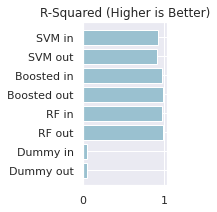

In [ ]:
metrics_r2 = {'Dummy out':abs(dr_r2_out), 'Dummy in':abs(dr_r2_in), 'RF out':r2_rfr_out, 
            'RF in':r2_rfr_in, 'Boosted out':r2_gbr_out, 'Boosted in':r2_gbr_in,
            'SVM out':r2_svm_out, 'SVM in':r2_svm_in}

import seaborn as sns
sns.set_theme()

f = plt.figure()
f.set_figwidth(1.5)
f.set_figheight(3)
plt.barh(range(len(metrics_r2)), list(metrics_r2.values()), tick_label=list(metrics_r2.keys()), color='#9ac1d0')
plt.title('R-Squared (Higher is Better)')
plt.show()

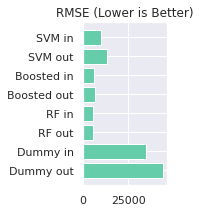

In [ ]:
metrics_rmse = {'Dummy out':rmse_dreg_out, 'Dummy in':rmse_dreg_in, 'RF out':rmse_rfr_out, 
            'RF in':rmse_rfr_in, 'Boosted out':rmse_gbr_out, 'Boosted in':rmse_gbr_in,
            'SVM out':rmse_svm_out, 'SVM in':rmse_svm_in}

f = plt.figure()
f.set_figwidth(1.5)
f.set_figheight(3)
plt.barh(range(len(metrics_rmse)), list(metrics_rmse.values()), tick_label=list(metrics_rmse.keys()), color='#66cdaa')
plt.title('RMSE (Lower is Better)')
plt.show()

In order of best to worst 
- Random Forest
- Gradient Boosted Regressor
- Support Vector Machines
- Logistic Regression
- Dummy Classifier (as expected)

Here we see that both root mean squared error and r squared are comparable with each other. The best model is a tie between Gradient Boosted Regressor and Random Forest Regressor. Likely, this is not only because these are powerful algorithms on small datasets but also because we were able to use gridsearchcv to find the best hyperparameters, which we were unable to do with our classifier models.

## What are the deciding factors of inflow/outflow in our best model (Random Forest)?
In this section, we conclude about the most important factors in the decision trees created in our random forest model.

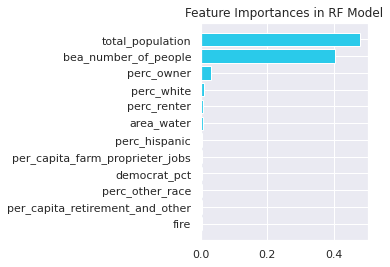

In [ ]:
import seaborn as sns
sns.set_theme()

num_features = 12

name_imp = [(x[0],x[1]) for x in zip(train.drop(fields_to_drop, axis=1).columns, rfr_in.feature_importances_)]
# print(name_imp)
name_imp = sorted(name_imp, key = lambda x: x[1], reverse=True)
# print(name_imp)
fields = [x[0] for x in name_imp][:num_features]
y_pos = np.arange(num_features)
importances = [x[1] for x in name_imp][:num_features]

importances = [importances[-i] for i in range(1, 1+len(importances))]
fields = [fields[-i] for i in range(1, 1+len(fields))]

fig = plt.figure()
plt.barh(y_pos, importances, align='center', color='#2ACAEA', tick_label=fields)
plt.title('Feature Importances in RF Model')
# ax.set_yticks(y_pos, labels=fields)
# ax.invert_yaxis()  # labels read top-to-bottom
# ax.set_xlabel('Importance')
# ax.set_title('Feature Importances in Random Forest')
fig.set_figwidth(3)
fig.set_figheight(4)

plt.show()

In [ ]:
# Create a heatmap of correlation of most important variables and inflow and outflow in training data
top_n = 10

heatmap_df = train[['individual_inflow', 'individual_outflow']]
for field in fields[-top_n:]:
    heatmap_df[field] = train[field]
heatmap_df.head()
corr_df = heatmap_df.corr().stack().reset_index().rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'})
corr_df['correlation'] = corr_df['correlation'].map('{:.2f}'.format)
corr_df

<ipython-input-34-ac20da67ed17>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_df[field] = train[field]


,variable,variable2,correlation
0,individual_inflow,individual_inflow,1.00
1,individual_inflow,individual_outflow,0.98
2,individual_inflow,perc_other_race,0.17
3,individual_inflow,democrat_pct,0.32
4,individual_inflow,per_capita_farm_proprieter_jobs,-0.41
...,...,...,...
139,total_population,perc_renter,0.40
140,total_population,perc_white,-0.40
141,total_population,perc_owner,-0.05
142,total_population,bea_number_of_people,1.00


In [ ]:
import altair as alt

axis_labels = [fields[-top_n:][-i] for i in range(1,top_n+1)]
axis_labels.insert(0, 'individual_outflow')
axis_labels.insert(0, 'individual_inflow')


base = alt.Chart(corr_df).encode(
    x=alt.X('variable2:O', sort=axis_labels),
    y=alt.Y('variable:O', sort=axis_labels)    
)

# Text layer with correlation labels
# Colors are for easier readability
text = base.mark_text().encode(
    text='correlation',
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)

# The correlation heatmap itself
cor_plot = base.mark_rect().encode(
    color='correlation:Q'
)

final = (cor_plot + text).properties(width=400,height=400)
final

alt.LayerChart(...)

Here we see the highest predictors of inflow and outflow. It looks like a higher population indicates both a higher inflow and a higher outflow. As you can see, both inflow and outflow are highly correlated with each other and population. 

There is also a slight correlation between the percentage of the population who owns property in the county. It looks like more people are moving into places with high ownership and out of places with lower ownership. That said, these correlations are very small. We also see that if the county has a greater proportion of white people, it is less likely to have people coming in and out of the county. This indicates that white communities in California are less transient.

We also see a positive correlation between the proportion of people renting and inflow/outflow. It looks like counties with higher proportions of renters imply that the communities are more transient. This is understandable.

There is also a positive correlation between both costal areas and hispanic populations. This indicates that costal parts of California have both higher populations and more transient populations. We also see that a larger hispanic population indiciates a higher inflow/outflow. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6c76417-5fde-42f3-8920-755838dec3fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>